<a href="https://colab.research.google.com/github/mmorari-cmyk/CURSO_SE.ALES_Y_SISTEMAS/blob/main/TALLER_2_SyS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Taller 2 SyS
# 1.1




# **Presente y describa el modelo que utiliza la FFT para el cálculo de los armónicos.**



###  Modelo FFT para el cálculo de los armónicos

La *FFT (Fast Fourier Transform)* es un algoritmo rápido para calcular la *DFT (Transformada Discreta de Fourier)*.  
La DFT modela un bloque de \( K \) muestras como una suma de armónicos discretos (exponenciales complejas) en una rejilla de frecuencias:

$$
f_n = \frac{n F_s}{K}, \quad n = 0, 1, \dots, K-1
$$

lo cual equivale a asumir que el bloque se repite cada \( K \) muestras (periodicidad circular).



###  Definición y síntesis de la DFT

$$
X[n] = \sum_{k=0}^{K-1} x_w[k] \, e^{-j2\pi nk / K}
$$
$$
x_w[k] = \frac{1}{K} \sum_{n=0}^{K-1} X[n] \, e^{j2\pi nk / K}
$$

Cada índice \( n \) representa un *bin* (armónico) en la frecuencia \( f_n \).



###  Amplitud y fase (para un tono alineado al bin \( m \))

Para una señal:
$$
x[k] = A \cos\left( \frac{2\pi m k}{K} + \phi \right)
$$
(sin desalineamiento de frecuencia):

$$
|X[m]| \approx \frac{K A}{2} \, C G_w, \qquad
A \approx \frac{2}{K \, C G_w} |X[m]|, \qquad
\phi \approx \angle X[m]
$$

donde \( C G_w \) es la *ganancia coherente* de la ventana  
(Rectangular = 1, Hann = 0.5).



###  Mapa bin–frecuencia

$$
f_n = \frac{n F_s}{K}, \qquad
\Delta f = \frac{F_s}{K}
$$

Si el fundamental real es \( F_0 \):

$$
m \approx \text{round}\left( \frac{F_0 K}{F_s} \right)
$$

sus armónicos ideales son:

$$
2m, 3m, \dots
$$

(si \( n F_0 \leq F_s/2 \)).



###  Pasos prácticos para medir armónicos con FFT

1. *Ventanea:*  
   $$
   x_w[k] = x[k] \, w[k]
   $$
   (por ejemplo, ventana Hann).

2. (Opcional) *Zero-padding* para refinar lectura de picos.

3. *FFT:*  
   Calcula \( X[n] \) y el eje de frecuencias \( f_n = n F_s / K \).

4. *Ubica:*  
   \( m \) (fundamental) y \( n_m \) (armónicos).

5. *Estima amplitud y fase:*
   $$
   A_n \approx \frac{2}{K \, C G_w} |X[n_m]|, \qquad
   \phi_n \approx \angle X[n_m]
   $$



###  Limitaciones esenciales

- *Nyquist:* solo se mide hasta \( F_s / 2 \) (por encima aparece aliasing).  
- *Fuga espectral:* si la frecuencia no cae en la rejilla, la energía se reparte en varios bins.  
  (Las ventanas reducen lóbulos laterales pero ensanchan el principal).  
- *Picket-fence:*  
  $$
  \Delta f = \frac{F_s}{K}
  $$
  El zero-padding densifica la rejilla pero *no añade información nueva*.

---


# **Realice una comparación del tiempo de cómputo requerido para el cálculo de la transformada discreta de Fourier utilizado la estimación por sumatoria vs la FFT. Pruebe distintos valores de longitud de la señal de entrada (4,8,16,32,64,128,256,512,1024,2048,4096). Presente una gráfica comparativa de los tiempos de ejecución en segundos vs la longitud de la señal de entrada.**


# Comparación de tiempos: DFT por sumatoria vs FFT
**Curso:** Señales y Sistemas  
**Estudiante:** Marlyn Nathalia Mora Riascos  

**Objetivo.** Comparar el tiempo de cómputo de la DFT por sumatoria (O(N²)) frente a la FFT (O(N log N)) para  
N = 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, y presentar una gráfica de tiempo (s) vs N (log–log).

## Metodología
- Se genera una señal aleatoria real \(x[n]\) de longitud \(N\).
- Para cada \(N\), se toma la **mediana** del tiempo medido sobre varias repeticiones (más repeticiones para N pequeños).
- **DFT por sumatoria**: implementación directa (O(N²)). Si la versión matricial consume mucha memoria, se usa una versión por bucle (misma complejidad temporal, menos memoria).
- **FFT**: `numpy.fft.fft` (O(N log N)).
- Se grafica tiempo vs \(N\) en **escala log–log**.


       N  Tiempo_DFT_sum (s)  Tiempo_FFT (s)
0      4            0.000027        0.000017
1      8            0.000033        0.000016
2     16            0.000044        0.000015
3     32            0.000117        0.000015
4     64            0.000322        0.000018
5    128            0.001997        0.000018
6    256            0.012195        0.000021
7    512            0.020736        0.000027
8   1024            0.082153        0.000041
9   2048            0.334986        0.000067
10  4096            1.400122        0.000144


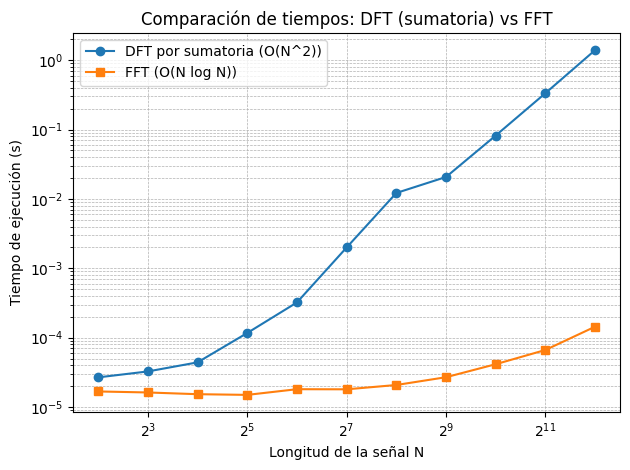

In [4]:
# Comparación de tiempos: DFT por sumatoria (O(N^2)) vs FFT (O(N log N))
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibilidad
rng = np.random.default_rng(12345)

# Longitudes solicitadas
Ns = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

# Número de repeticiones para promediar (más repeticiones en N pequeños, menos en N grandes)
def reps_for_N(N):
    if N <= 128:
        return 7
    elif N <= 512:
        return 5
    elif N <= 2048:
        return 3
    else:
        return 2  # 4096 puede ser más costoso

# DFT por sumatoria usando multiplicación matricial (O(N^2))
# Usamos float32/complex64 para reducir memoria y evitar fallas con N grandes.
def dft_sum(x):
    N = x.shape[0]
    n = np.arange(N, dtype=np.float32)
    k = n.reshape(-1, 1)
    W = np.exp(-2j * np.pi * (k @ n.reshape(1, -1)) / np.float32(N)).astype(np.complex64)
    return (W @ x.astype(np.complex64))

# FFT usando NumPy (O(N log N))
def fft_np(x):
    return np.fft.fft(x)

# Medición robusta (mediana del tiempo de varias repeticiones)
def median_time(func, x, reps):
    times = []
    for _ in range(reps):
        t0 = time.perf_counter()
        _ = func(x)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return float(np.median(times))

# Ejecutar mediciones
rows = []
for N in Ns:
    reps = reps_for_N(N)
    x = rng.standard_normal(N, dtype=np.float64)  # misma señal para ambos métodos

    t_fft = median_time(fft_np, x, reps)

    try:
        t_dft = median_time(dft_sum, x, reps)
    except Exception as e:
        # Si no alcanza memoria para la DFT matricial, lo registramos como NaN
        t_dft = np.nan

    rows.append({"N": N, "Tiempo_DFT_sum (s)": t_dft, "Tiempo_FFT (s)": t_fft})

df = pd.DataFrame(rows)
print(df)

# Guardar CSV (opcional)
df.to_csv("tiempos_dft_vs_fft.csv", index=False)

# Gráfica comparativa (log–log)
plt.figure()
plt.plot(df["N"], df["Tiempo_DFT_sum (s)"], marker="o", label="DFT por sumatoria (O(N^2))")
plt.plot(df["N"], df["Tiempo_FFT (s)"], marker="s", label="FFT (O(N log N))")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("Longitud de la señal N")
plt.ylabel("Tiempo de ejecución (s)")
plt.title("Comparación de tiempos: DFT (sumatoria) vs FFT")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


# Consulte en qué consiste la frecuencia de -3dB y su relación con las frecuencias de corte en el filtrado espectral de señales.


Definición:
La *frecuencia de −3 dB* es el punto de la respuesta en frecuencia donde la ganancia de **amplitud** cae a  
$|H(f)| = 10^{-3/20} \approx 0.7071 = \frac{1}{\sqrt{2}}$  
respecto al nivel de referencia de la banda pasante. En términos de **potencia**, −3 dB equivale a reducir la potencia a la mitad:  
$$10\log_{10}\!\left(\frac{P}{P_0}\right) = -3\,\text{dB}
\;\Longleftrightarrow\;
\frac{P}{P_0}=\frac{1}{2}.$$

**Relación con las frecuencias de corte.**  
- En **pasa-bajos** y **pasa-altos**, la **frecuencia de corte** $f_c$ se define típicamente en el punto de −3 dB.  
- En **pasa-banda** hay dos cortes (ambos a −3 dB): $f_L$ (corte inferior) y $f_H$ (corte superior). De ahí:  
$$\text{BW} = f_H - f_L,\qquad
f_0 \approx \sqrt{f_L\,f_H}\ \text{(bandas estrechas)},\qquad
Q = \frac{f_0}{\text{BW}}.$$

**¿Por qué −3 dB?**  
Porque corresponde a **mitad de potencia** (≈70.7% en amplitud), dando un criterio claro y estándar para delimitar el fin de la banda pasante.  
En un filtro **Butterworth** normalizado se cumple $|H(j\omega_c)|^2=\tfrac12$ para cualquier orden, por lo que el corte está exactamente en −3 dB.

**En filtrado espectral (FFT).**  
Al filtrar en el dominio de la **FFT** (enmascarando componentes), los bordes reales no son ideales. Los puntos de **−3 dB** se usan como *frecuencias de corte efectivas* para:
- delimitar la banda útil (pasa-bajos/altos/banda),
- medir **ancho de banda** y comparar diseños/ventanas (p. ej., “ancho del lóbulo principal a −3 dB”).  

Para sistemas discretos, si $\Omega_c$ es la frecuencia digital (rad/muestra) y $f_s$ la frecuencia de muestreo:  
$$f_c = \frac{\Omega_c}{2\pi}\,f_s.$$

**Resumen.**  
- −3 dB $= 0.707$ en amplitud $= 1/2$ en potencia.  
- Las **frecuencias de corte** se fijan típicamente en −3 dB y definen los bordes de la banda útil.  
- En **pasa-banda**: $f_L, f_H$ a −3 dB $\Rightarrow$ $\text{BW}=f_H-f_L$, $f_0 \approx \sqrt{f_L f_H}$, $Q=f_0/\text{BW}$.
---

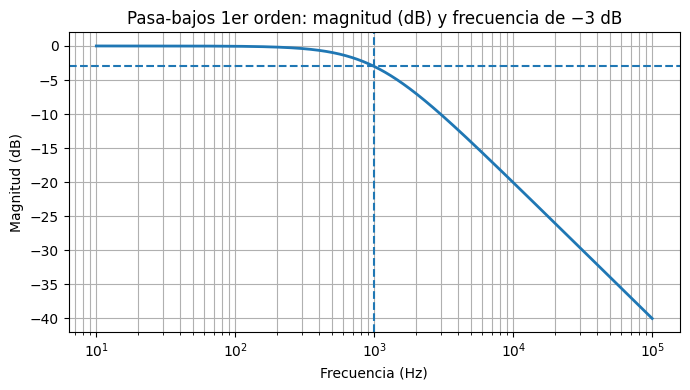

In [3]:
#Gráfica ilustrativa de −3 dB en un pasa-bajos de 1er orden

import numpy as np
import matplotlib.pyplot as plt

fc = 1000.0  # Hz
f = np.logspace(1, 5, 1000)  # 10 Hz a 100 kHz

H = 1.0 / np.sqrt(1.0 + (f/fc)**2)
HdB = 20*np.log10(H)

plt.figure(figsize=(7,4))
plt.semilogx(f, HdB, linewidth=2)
plt.axhline(-3, linestyle='--')
plt.axvline(fc, linestyle='--')
plt.title('Pasa-bajos 1er orden: magnitud (dB) y frecuencia de −3 dB')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


# 1.2
Explique las semejanzas y diferencias entre la serie de Fourier (exponencial, trigonométrica y compacta), la transformada de Fourier, transformada de Fourier en tiempo discreto (DTFT) y transformada discreta de Fourier (DFT). Considere las diferentes combinaciones entre: espectro continuo y discreto y señal en tiempo continuo y discreto. Además, consulte en qué consiste el algoritmo Fast Fourier Transform (FFT) y su utilidad para el cálculo de la transformada discreta de Fourier. Explique en detalle el algoritmo FFT y su costo computacional vs el de la transformada discreta. Ver cuaderno Transformada de Fourier.

# Fourier “en una sola pasada”: qué usar, cuándo y por qué (SF, FT, DTFT, DFT y FFT)

## 1) Procedimiento general para resolver el ejercicio
1. **Clasifica la señal**:
   - ¿Es **tiempo continuo** \(x(t)\) o **tiempo discreto** \(x[n]\)?
   - ¿Es **periódica** o **aperiódica**? ¿Finita (longitud \(N\)) o infinita?

2. **Elige la herramienta adecuada** (según 1):
   - **Continuo + Periódica** → **Serie de Fourier** (SF).
   - **Continuo + Aperiódica** → **Transformada de Fourier** (FT).
   - **Discreto + Aperiódica** → **DTFT**.
   - **Discreto + Finita (long. \(N\))** → **DFT** (y computacionalmente **FFT** para calcularla).

3. **Determina la “textura” del espectro**:
   - **Periódica en tiempo** → **Espectro discreto** (líneas).
   - **Aperiódica en tiempo** → **Espectro continuo**.
   - **Discreta en tiempo** → espectro **periódico** en frecuencia (DTFT y DFT).

4. **Aplica la fórmula correspondiente** (ver Secc. 2–5) y relaciona equivalencias:
   - SF trig ↔ SF exp ↔ SF compacta (misma info).
   - DFT = **muestras** de la DTFT en rejilla uniforme.
   - FT de periódica = tren de impulsos (caso SF).

5. **(Si se requiere cómputo)**: para DFT usa **FFT** por eficiencia (ver Secc. 6–7).

---

## 2) Serie de Fourier (tiempo continuo, **periódica**) ⇒ **espectro discreto**
**Trigonométrica**  
$$
x(t)=\frac{a_0}{2}+\sum_{n=1}^{\infty}\big[a_n\cos(n\omega_0 t)+b_n\sin(n\omega_0 t)\big],\quad \omega_0=\frac{2\pi}{T}.
$$

**Exponencial**  
$$
x(t)=\sum_{n=-\infty}^{\infty} c_n\,e^{j n \omega_0 t},\qquad
c_n=\frac{1}{T}\int_T x(t)\,e^{-j n \omega_0 t}\,dt.
$$

**Compacta (magnitud–fase)**  
$$
x(t)=\frac{a_0}{2}+\sum_{n=1}^{\infty} A_n \cos\!\big(n\omega_0 t+\phi_n\big),
\quad A_n=\sqrt{a_n^2+b_n^2},\ \ \phi_n=\tan^{-1}\!\left(\frac{-b_n}{a_n}\right).
$$

**Conexiones**:  
$$a_n=c_n+c_{-n},\qquad b_n=j(c_n-c_{-n}).$$  
**Idea clave**: periodicidad en tiempo ⇒ líneas en múltiplos de \(\omega_0\).

---

## 3) Transformada de Fourier (FT) (tiempo continuo, **aperiódica**) ⇒ **espectro continuo**
$$
X(\omega)=\int_{-\infty}^{\infty} x(t)\,e^{-j\omega t}\,dt,\qquad
x(t)=\frac{1}{2\pi}\int_{-\infty}^{\infty} X(\omega)\,e^{j\omega t}\,d\omega.
$$

Si \(x(t)\) fuese periódica, su FT es un **tren de impulsos** (caso Serie de Fourier).

---

## 4) DTFT (tiempo **discreto**, **aperiódica**) ⇒ **espectro continuo y periódico** en \(2\pi\)
$$
X(e^{j\omega})=\sum_{n=-\infty}^{\infty} x[n]\ e^{-j\omega n},\qquad \omega\in(-\pi,\pi].
$$
- Continuo en \(\omega\) pero **periódico** con periodo \(2\pi\).

---

## 5) DFT (tiempo **discreto**, **finita** de longitud \(N\)) ⇒ **espectro discreto y periódico**
$$
X[k]=\sum_{n=0}^{N-1} x[n]\ e^{-j\frac{2\pi}{N}kn},\quad
x[n]=\frac{1}{N}\sum_{k=0}^{N-1} X[k]\ e^{j\frac{2\pi}{N}kn},\quad k=0,\dots,N-1.
$$
- La DFT toma **muestras** de la DTFT en \(\omega_k=2\pi k/N\).
- Asume extensión **periódica** de \(x[n]\) con periodo \(N\).

---

## 6) Mapa unificador (tiempo vs espectro)
- **Continuo + Periódica (SF)** → **Espectro discreto** (líneas).
- **Continuo + Aperiódica (FT)** → **Espectro continuo**.
- **Discreto + Aperiódica (DTFT)** → **Espectro continuo y periódico** en \(2\pi\).
- **Discreto + Finita (DFT)** → **Espectro discreto y periódico** (muestras de DTFT).

**Reglas mentales**:
- Periodicidad en **tiempo** ⇒ **discreción** en **frecuencia**.  
- Aperiodicidad en **tiempo** ⇒ **continuidad** en **frecuencia**.  
- Muestrear/ventanear en tiempo impacta periodicidad/anchura en frecuencia.

---

## 7) ¿Qué es la FFT y para qué sirve?
La **FFT (Fast Fourier Transform)** es una **familia de algoritmos** para **calcular la DFT** de forma eficiente.

- **Costo DFT directa:** $$O(N^2)$$ (cada \(X[k]\) suma \(N\) términos, y hay \(N\) salidas).
- **Costo FFT (p.ej., Cooley–Tukey radix-2):** $$O(N\log_2 N)$$  
  Ej.: \(N=4096\) → \(N^2\approx 16.8\) millones vs \(N\log_2 N\approx 49{,}152\).

**Utilidad**: hace **viable** el análisis espectral, convolución rápida (filtrado por frecuencia), comunicaciones (OFDM), audio, imagen, radar, etc.

---

## 8) FFT en detalle: idea del algoritmo (Cooley–Tukey radix-2, DIT)
**Suposición**: \(N=2^m\). (Para otros \(N\) hay variantes radix-mixta, Bluestein, Rader, etc.)

1. **Divide** la secuencia en **pares** e **impares**:  
   \(x_e[n]=x[2n]\), \(x_o[n]=x[2n+1]\) (cada una de longitud \(N/2\)).
2. **Computa** dos DFTs pequeñas: \(E[k]=\text{DFT}(x_e)\), \(O[k]=\text{DFT}(x_o)\).
3. **Combina** con **mariposas** (butterflies) usando factores “twiddle” \(W_N=e^{-j\frac{2\pi}{N}}\):
   $$
   X[k]=E[k]+W_N^k\,O[k],\quad
   X[k+N/2]=E[k]-W_N^k\,O[k],\quad k=0,\dots,\frac{N}{2}-1.
   $$
4. **Recursiona** hasta llegar a DFTs de tamaño 2/4 (triviales).  
   - Niveles: \(\log_2 N\).  
   - Trabajo por nivel: \(\approx N\).  
   - **Total**: \(\approx N\log_2 N\).

**Notas prácticas**:
- **DIT** (decimation-in-time) y **DIF** (decimation-in-frequency) cambian el orden de operaciones, no la complejidad.
- Para \(N\) no potencia de 2: usar **radix-mixta** o **Bluestein**.
- En cómputo real: usar librerías optimizadas (NumPy/FFTW/CuFFT).

---

## 9) Conexiones prácticas (DFT ↔ DTFT ↔ FT/SF)
- **DFT ≈ DTFT muestreada** para una señal **finita** (o **ventaneada**).  
- **Zero-padding** refina la malla en frecuencia (no agrega nueva información física).  
- **Leakage**: si la ventana \(N\) no contiene un número entero de períodos, aparece derrame espectral; mitigar con **ventanas** (Hann, Hamming, Blackman).

---

## 10) Conclusión operativa para el informe
- Si la señal es **continua periódica**, use **Serie de Fourier** (formas trig/exponencial/compacta = misma info).  
- Si es **continua aperiódica**, use **FT** (espectro continuo).  
- Si es **discreta aperiódica**, use **DTFT** (continuo y **periódico**).  
- Si es **discreta finita**, use **DFT**; **cómprela con FFT** (es la *misma* DFT, pero computada en \(O(N\log N)\) en lugar de \(O(N^2)\)).  
- La **FFT** no es otra transformada: es *el algoritmo rápido* que hace posible el cálculo de la **DFT** en la práctica.





# 1.3

Encuentre la funcion de densidad espectral (transformada de ´
Fourier) para las siguientes senales (sin aplicar propiedades): ˜
a) e
−a|t|
, a∈R
+; b) cos (wct), wc∈R; c) sin (wst), ws∈R;
d) f(t) cos (wct), wc∈R, f(t)∈R,C; e) e
−a|t|
2
, a∈R
+. f)
Arectd(t), A, d∈R.

Transformada de Fourier de señales básicas

a) $f(t)=e^{-a|t|},\ a>0$}

Separando la integral en $$[0,\infty) y (-\infty,0]$$:

$$
F(\omega)
= \int_{-\infty}^{\infty} e^{-a|t|} e^{-j\omega t}\,dt
= \int_{0}^{\infty} e^{-(a+j\omega)t}\,dt
+ \int_{0}^{\infty} e^{-(a-j\omega)t}\,dt
$$

$$
F(\omega)
= \frac{1}{a+j\omega} + \frac{1}{a-j\omega}
= \frac{2a}{a^2 + \omega^2}
$$

Por tanto,

$$
\boxed{F\{e^{-a|t|}\}(\omega) = \frac{2a}{a^2 + \omega^2},\quad a>0}
$$



b) $f(t)=\cos(\omega_c t)$

Usando la identidad de Euler:

$$
\cos(\omega_c t)=\frac{1}{2}\left(e^{j\omega_c t}+e^{-j\omega_c t}\right)
$$

La transformada de $e^{j\omega_c t}$ es $2\pi\delta(\omega-\omega_c)$ bajo la convención
$F(\omega)=\int f(t)e^{-j\omega t}\,dt$.
Por linealidad:

$$
F\{\cos(\omega_c t)\}(\omega)
= \frac{1}{2}\big[2\pi\delta(\omega-\omega_c) + 2\pi\delta(\omega+\omega_c)\big]
$$

$$
\boxed{F\{\cos(\omega_c t)\}(\omega)
= \pi\big[\delta(\omega-\omega_c)+\delta(\omega+\omega_c)\big]}
$$


c) $f(t)=\sin(\omega_c t)$

Recordando que

$$
\sin(\omega_c t)=\frac{1}{2j}\left(e^{j\omega_c t}-e^{-j\omega_c t}\right)
$$

se obtiene:

$$
F\{\sin(\omega_c t)\}(\omega)
= \frac{1}{2j}\big[2\pi\delta(\omega-\omega_c) - 2\pi\delta(\omega+\omega_c)\big]
$$

$$
\boxed{F\{\sin(\omega_c t)\}(\omega)
= j\pi\big[\delta(\omega-\omega_c) - \delta(\omega+\omega_c)\big]}
$$


d) $f(t)=A\,\mathrm{rect}\!\left(\frac{t}{d}\right)$

Definimos $\mathrm{rect}(t/d)=1$ para $|t|<d/2$ y $0$ fuera. Entonces:

$$
F(\omega)
= A \int_{-d/2}^{d/2} e^{-j\omega t}\,dt
= A\left[\frac{e^{-j\omega t}}{-j\omega}\right]_{-d/2}^{d/2}
= A\frac{2\sin(\omega d/2)}{\omega}
$$

Usando la función sinc no normalizada $\mathrm{sinc}(x)=\frac{\sin x}{x}$:

$$
\boxed{F\{A\,\mathrm{rect}(t/d)\}(\omega)
= A\,d\,\mathrm{sinc}\!\left(\frac{\omega d}{2}\right)
= A\frac{2\sin(\omega d/2)}{\omega}}
$$

(la equivalencia se obtiene multiplicando y dividiendo por
𝑑
/
2
d/2.)

# 1.4

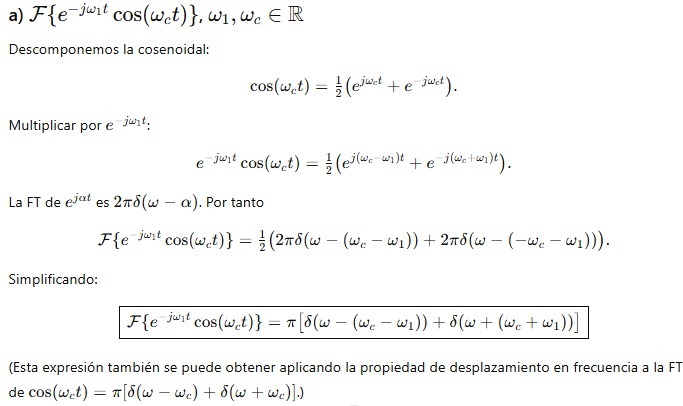